In [14]:
import os
os.getcwd()

'C:\\'

Epoch 1/20


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0042
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

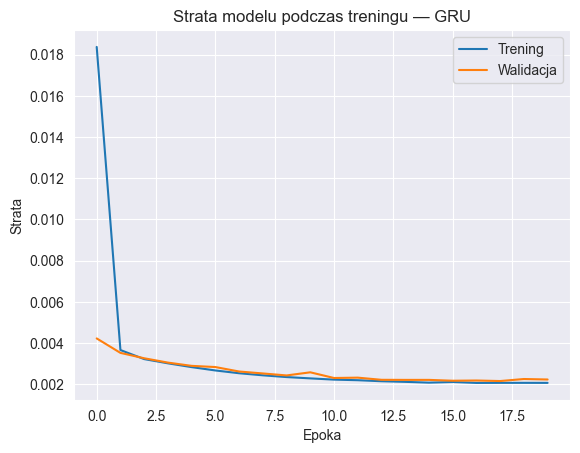

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


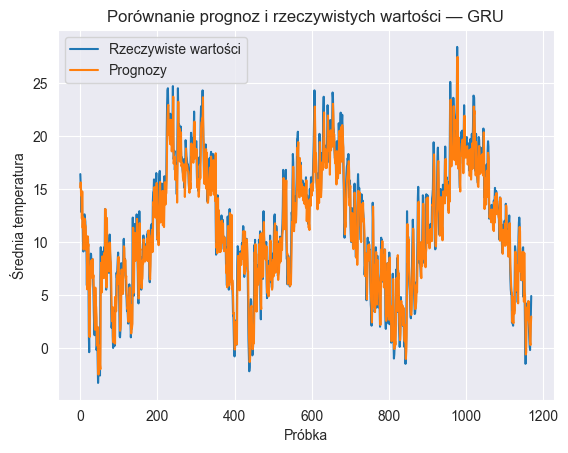

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prognozy na 5 dni do przodu (średnia temperatura):
[[2.9668968]
 [2.7033548]
 [2.6591864]
 [2.740953 ]
 [2.830788 ]]


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
# =========================
# Wczytanie i przygotowanie danych
# =========================
df = pd.read_csv(
    "european_capitals_history_clean.csv",
    parse_dates=["date"]
)

df_city = df[df['city'] == 'Warszawa']
df_city = df_city[['date', 'city', 'tavg']]
df_city.sort_values(by=["date"], inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================
def create_sequences(df, window=5):
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df.iloc[i:i + window]['tavg'].values
        label = df.iloc[i + window]['tavg']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(df_city, window=5)

# =========================
# Normalizacja danych
# =========================
scaler = MinMaxScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
labels_scaled = scaler.transform(labels.reshape(-1, 1))
sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(sequences_scaled) * 0.8)
X_train = sequences_scaled[:train_size]
X_test  = sequences_scaled[train_size:]
y_train = labels_scaled[:train_size]
y_test  = labels_scaled[train_size:]

# =========================
# Budowa modelu GRU
# =========================
model = Sequential()
model.add(
    GRU(
        units=50,
        return_sequences=False,
        input_shape=(X_train.shape[1], 1)
    )
)
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# =========================
# Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# =========================
# Zapis modelu do folderu "models"
# =========================
model_dir = "models"
model_path = os.path.join(model_dir, "gru_warszawa_temperature.keras")
os.makedirs(model_dir, exist_ok=True)
model.save(model_path)
print(f"Model zapisany w lokalizacji: {model_path}")

# =========================
# Wizualizacja funkcji straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu — GRU")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.plot(y_test_rescaled, label='Rzeczywiste wartości')
plt.plot(predictions_rescaled, label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — GRU")
plt.xlabel("Próbka")
plt.ylabel("Średnia temperatura")
plt.show()

# =========================
# Prognoza na 5 dni w przyszłość
# =========================
future_predictions = []
input_sequence = X_test[-1]  # (5, 1)

for _ in range(5):
    pred_scaled = model.predict(
        input_sequence.reshape(1, 5, 1)
    )
    future_predictions.append(pred_scaled[0][0])
    input_sequence = np.roll(input_sequence, -1)
    input_sequence[-1] = pred_scaled

future_predictions_rescaled = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

print("Prognozy na 5 dni do przodu (średnia temperatura):")
print(future_predictions_rescaled)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# =========================
# Funkcja budująca model GRU (2 warstwy + Dropout)
# =========================
def build_gru_model(input_shape):
    model = Sequential()
    # Pierwsza warstwa GRU – zwraca sekwencję
    model.add(GRU(
        units=64,
        return_sequences=True,
        input_shape=input_shape
    ))
    model.add(Dropout(0.2))
    # Druga warstwa GRU – tylko ostatnia wartość
    model.add(GRU(
        units=32,
        return_sequences=False
    ))
    # Wyjście
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    return model

# =========================
# Time Series Cross-Validation (Walk-Forward)
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores  = []
mse_scores  = []
r2_scores   = []

fold = 1

for train_index, test_index in tscv.split(sequences_scaled):
    print(f"\nFold {fold}")

    X_train = sequences_scaled[train_index]
    X_test  = sequences_scaled[test_index]

    y_train = labels_scaled[train_index]
    y_test  = labels_scaled[test_index]

    model = build_gru_model(
        input_shape=(X_train.shape[1], 1)
    )

    # =========================
    # EarlyStopping
    # =========================
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=0,
        shuffle=False   # KLUCZOWE dla szeregów czasowych
    )

    # =========================
    # Predykcja
    # =========================
    y_pred = model.predict(X_test)

    # Odwrócenie skalowania
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2   = r2_score(y_test_rescaled, y_pred_rescaled)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(
        f"R²: {r2:.4f} | "
        f"MAE: {mae:.4f} | "
        f"MSE: {mse:.4f} | "
        f"RMSE: {rmse:.4f}"
    )

    fold += 1

# =========================
# Podsumowanie
# =========================
print("\nWalk-Forward Cross-Validation — GRU (2 warstwy + EarlyStopping)")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



Fold 1


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R²: 0.9005 | MAE: 1.4363 | MSE: 3.3528 | RMSE: 1.8311

Fold 2


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R²: 0.8974 | MAE: 1.4264 | MSE: 3.4420 | RMSE: 1.8553

Fold 3


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R²: 0.9025 | MAE: 1.5252 | MSE: 3.7217 | RMSE: 1.9292

Fold 4


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R²: 0.8910 | MAE: 1.4131 | MSE: 3.4960 | RMSE: 1.8697

Fold 5


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R²: 0.8992 | MAE: 1.4571 | MSE: 3.5314 | RMSE: 1.8792

Walk-Forward Cross-Validation — GRU (2 warstwy + EarlyStopping)
R²   : 0.8981
MAE  : 1.4516
MSE  : 3.5088
RMSE : 1.8729


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


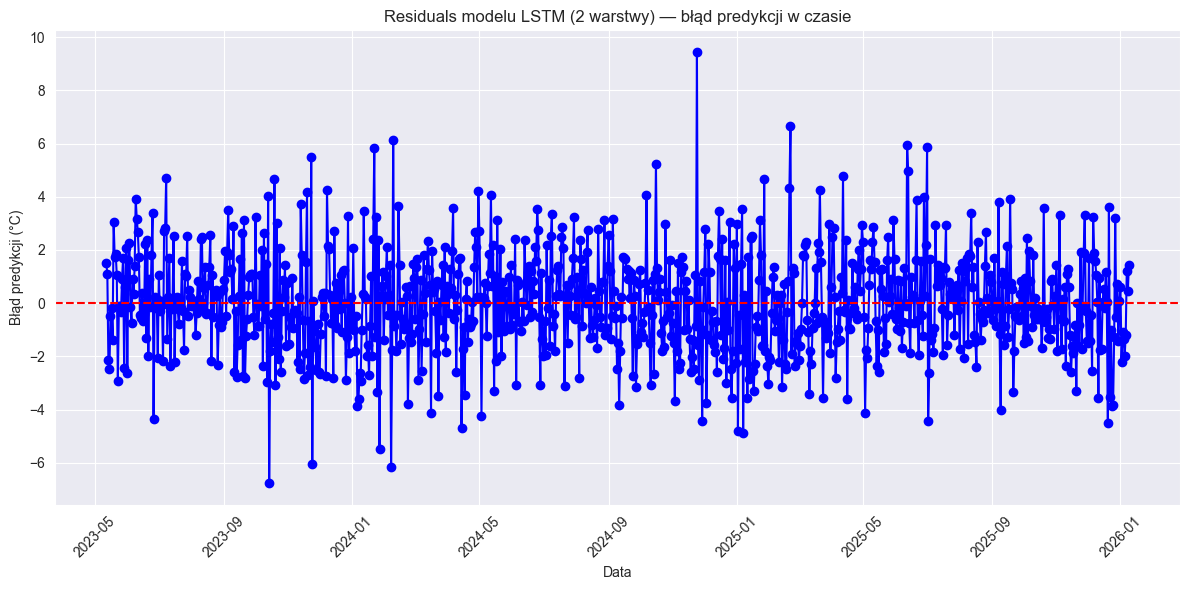

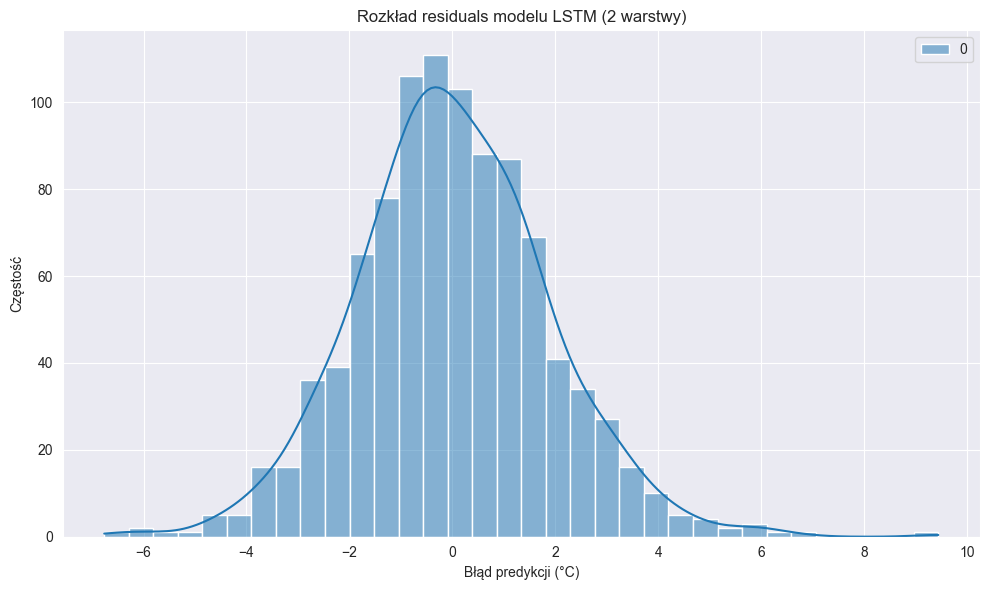

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Dopasowanie długości (czasem w LSTM występuje różnica długości)
min_len = min(len(y_test_rescaled), len(predictions_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
predictions_rescaled = predictions_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - predictions_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['date'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='b'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu LSTM (2 warstwy) — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='b')
plt.title('Rozkład residuals modelu LSTM (2 warstwy)')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/20


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0241 - val_loss: 0.0047
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

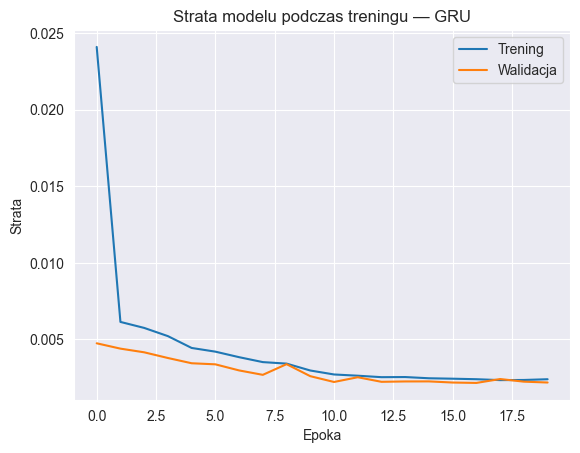

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


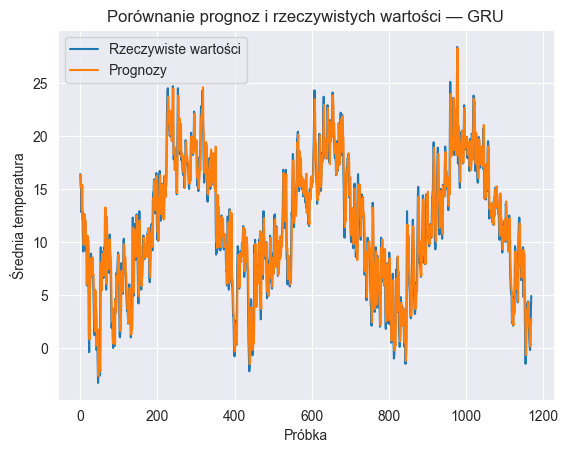

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prognozy na 5 dni do przodu (średnia temperatura):
[[2.7318337]
 [2.3016717]
 [2.106562 ]
 [2.0574267]
 [2.019448 ]]


In [ ]:
from keras.src.layers import LSTM
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
# =========================
# Wczytanie i przygotowanie danych
# =========================
df = pd.read_csv(
    "european_capitals_history_clean.csv",
    parse_dates=["date"]
)

df_city = df[df['city'] == 'Warszawa']
df_city = df_city[['date', 'city', 'tavg']]
df_city.sort_values(by=["date"], inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================
def create_sequences(df, window=5):
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df.iloc[i:i + window]['tavg'].values
        label = df.iloc[i + window]['tavg']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(df_city, window=5)

# =========================
# Normalizacja danych
# =========================
scaler = MinMaxScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
labels_scaled = scaler.transform(labels.reshape(-1, 1))
sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(sequences_scaled) * 0.8)
X_train = sequences_scaled[:train_size]
X_test  = sequences_scaled[train_size:]
y_train = labels_scaled[:train_size]
y_test  = labels_scaled[train_size:]

# =========================
# Budowa modelu GRU
# =========================
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# =========================
# Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# =========================
# Zapis modelu do folderu "models"
# =========================
model_dir = "models"
model_path = os.path.join(model_dir, "gru_warszawa_temperature.keras")
os.makedirs(model_dir, exist_ok=True)
model.save(model_path)
print(f"Model zapisany w lokalizacji: {model_path}")

# =========================
# Wizualizacja funkcji straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu — GRU")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.plot(y_test_rescaled, label='Rzeczywiste wartości')
plt.plot(predictions_rescaled, label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — GRU")
plt.xlabel("Próbka")
plt.ylabel("Średnia temperatura")
plt.show()

# =========================
# Prognoza na 5 dni w przyszłość
# =========================
future_predictions = []
input_sequence = X_test[-1]  # (5, 1)

for _ in range(5):
    pred_scaled = model.predict(
        input_sequence.reshape(1, 5, 1)
    )
    future_predictions.append(pred_scaled[0][0])
    input_sequence = np.roll(input_sequence, -1)
    input_sequence[-1] = pred_scaled

future_predictions_rescaled = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

print("Prognozy na 5 dni do przodu (średnia temperatura):")
print(future_predictions_rescaled)
